In [1]:
import numpy as np
import math
from scipy.fft import fft
import matplotlib.pyplot as plt
from scipy.fft import irfft

<b>Читаем данные</b>

In [2]:
with open('data_test.dat', 'rb') as f:
    data = np.fromfile(f, dtype=np.float32)

<b>Задаем константы</b>

In [3]:
fs = 50000
f0 = 5000
f1 = 8000
t = 0.2
K = t * f0 * f1 / (f1 - f0)
tk = t / 2. * (f0 + f1) / (f1 - f0)
print(K, tk)

2666.6666666666665 0.43333333333333335


In [4]:
def sig(x):
    return np.cos(2 * math.pi * K * np.log(1 - x/tk))

In [5]:
gfm = np.zeros(data.shape[0])
gfm_short = np.linspace(0, 0.2, fs//5)
gfm[0:fs//5] = gfm_short
gfm = sig(gfm)
gfm_short = sig(gfm_short)
gfm[fs//5:] = 0
print(gfm.shape, gfm_short.shape)

(2999808,) (10000,)


<b>График исходного сигнала</b>

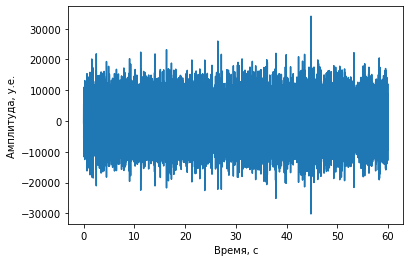

In [6]:
plt.xlabel('Время, с')
plt.ylabel('Амплитуда, у.е.')
plt.plot([i/fs for i in range(data.shape[0])], data)

<b>Энергетический спектр исходного сигнала</b>

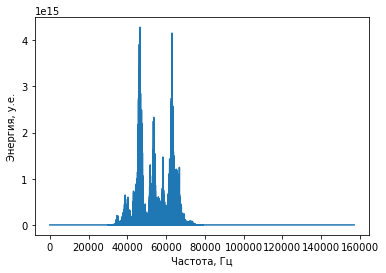

In [7]:
spectrum = fft(data)
spectrum_eg = np.square(abs(spectrum[0:spectrum.shape[0]//2]))
plt.xlabel('Частота, Гц')
plt.ylabel('Энергия, у.е.')
plt.plot([math.pi*2/60*(i) for i in range(spectrum_eg.shape[0])], spectrum_eg)

<b>График ГЧМ</b>

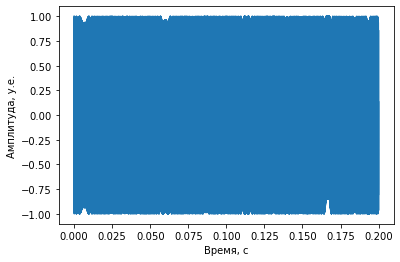

In [8]:
plt.xlabel('Время, с')
plt.ylabel('Амплитуда, у.е.')
plt.plot([i/fs for i in range(gfm_short.shape[0])], gfm_short)

<b>Энергетический спектр ГЧМ</b>

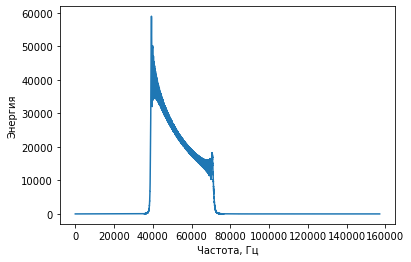

In [25]:
spectrum1 = fft(gfm)
spectrum_eg1 = np.square(abs(spectrum1[0:spectrum1.shape[0]//2]))
plt.xlabel('Частота, Гц')
plt.ylabel('Энергия')
plt.plot([math.pi*2/60*(i) for i in range(spectrum_eg1.shape[0])], spectrum_eg1)

<b>Взаимный спектр</b>

In [26]:
spectrum12 = np.conj(spectrum1[0:spectrum1.shape[0]//2]) * spectrum[0:spectrum.shape[0]//2]

<b>Модуль ненормированной ковариации</b>

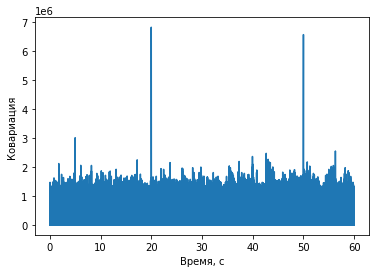

In [27]:
corr = abs(irfft(spectrum12))
plt.xlabel('Время, с')
plt.ylabel('Ковариация')
plt.plot([i/fs for i in range(corr.shape[0])],corr)

<b>Проверим по определению через свертку</b>

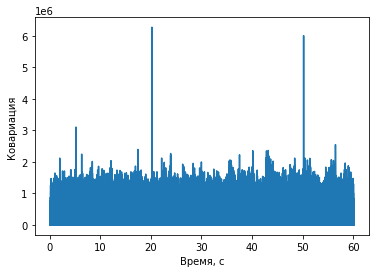

In [28]:
y = abs(np.correlate(gfm_short,data, mode = 'full'))
plt.xlabel('Время, с')
plt.ylabel('Ковариация')
plt.plot([i/fs for i in range(y.shape[0])],y[::-1])

Действительно, результаты совпадают с точностью до погрешности вычислений прямого и обратного дискретного преобразования Фурье.
<h1>Выводы</h1>
Из графика ковариации можно заметить два наложения с задержками 20 и 50с. Учитывая, что амплитуда сигнала имеет порядок 10e3, а данные
аномалии 10e6, можно утверждать, что и амплитуда синтезированных ГЧМ сигналов будет порядка 10e3.

<b>Автоматический алгоритм детектирования</b>

In [29]:
def detect_gfm(signal, gfm_sample, fs):
    spectrum = fft(signal)
    spectrum1 = fft(gfm_sample)
    spectrum12 = np.conj(spectrum1[0:spectrum1.shape[0]//2]) * spectrum[0:spectrum.shape[0]//2]
    corr = abs(irfft(spectrum12))
    bound = np.max(corr)/2
    return(np.unique(np.rint(np.argwhere(corr>bound)/fs)))

In [30]:
detect_gfm(data,gfm,fs)

array([20., 50.])